In [3]:
# import warnings
# from pathlib import Path

# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# data_dir = Path('../data')
# figure_dir = Path('../figures')
# figure_dir.mkdir(exist_ok=True)
# warnings.simplefilter(action='ignore', category=FutureWarning)

# district_codes = pd.read_csv(data_dir / 'district_codes_1878.csv')
# district_codes = {k: v for k, v in district_codes.itertuples(index=False)}
# institutions = pd.read_csv(data_dir / 'institutions.csv', dtype={'district': str, 'plot_number': str})

# districts_in_city = [
#     'Valli',
#     'Salakkalahti',
#     'Repola',
#     'Anina',
#     'Papula',
#     'P_Annan_kruunu',
#     'Hiekka',
#     'Pantsarlahti',
#     'Viipurin_esikaupunki',
#     'Paulovski',
#     'Havi',
#     'Saunalahti',
#     'Pietarin_esikaupunki',
# ]

# poll_tax = pd.read_csv(data_dir / 'poll_tax_register.csv', index_col=0)
# poll_tax['orthodox'] = poll_tax['orthodox'].interpolate(method='linear')
# poll_tax['in_russia_orthodox'] = poll_tax['in_russia_orthodox'].interpolate(method='linear', limit=2).fillna(0)
# poll_tax['total'] = (poll_tax.total_women + poll_tax.total_men).interpolate(method='linear')
# remove = poll_tax.in_russia_orthodox.copy()
# remove.loc['1906':] = 0
# poll_tax['orthodox'] = poll_tax.orthodox - remove
# health_council = pd.read_csv(data_dir / 'health_council.csv', index_col=0).pop_orthodox
# health_council = health_council.reindex(range(1880, 1921), fill_value=np.nan).interpolate(method='slinear')
# foreigners = pd.read_csv(data_dir / 'foreigners.csv', index_col=0).russia
# language = pd.read_csv(data_dir / 'language.csv', index_col=0).russian
# religion = pd.read_csv(data_dir / 'religion.csv', index_col=0).orthodox
# difference = health_council - poll_tax.orthodox
# data = pd.DataFrame([
#     difference,
#     poll_tax.orthodox,
#     poll_tax.in_russia_orthodox,
#     poll_tax.total,
#     health_council,
#     foreigners,
#     language,
#     religion,
# ]).T
# data.columns = [
#     'difference',
#     'register_orthodox',
#     'orthodox_in_russia',
#     'register_total',
#     'health_council_orthodox',
#     'Russian_citizens',
#     'Russian_speakers',
#     'census_orthodox',
# ]
# data.interpolate(method='linear', inplace=True)
# data.plot(marker='+', legend=True, figsize=(10, 7), ylim=(0, 25_000))
# plt.savefig(figure_dir / 'timeseries1.png')
# data.plot(marker='+', legend=True, figsize=(10, 7), ylim=(0, 4_000))
# plt.savefig(figure_dir / 'timeseries2.png')

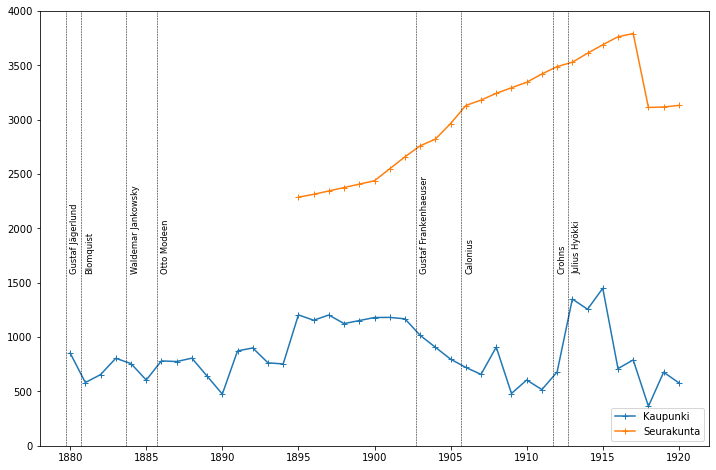

In [8]:
import warnings
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_dir = Path('../data')
figure_dir = Path('../figures')
figure_dir.mkdir(exist_ok=True)
warnings.simplefilter(action='ignore', category=FutureWarning)

district_codes = pd.read_csv(data_dir / 'district_codes_1878.csv')
district_codes = {k: v for k, v in district_codes.itertuples(index=False)}
institutions = pd.read_csv(data_dir / 'institutions.csv', dtype={'district': str, 'plot_number': str})

districts_in_city = [
    'Valli',
    'Salakkalahti',
    'Repola',
    'Anina',
    'Papula',
    'P_Annan_kruunu',
    'Hiekka',
    'Pantsarlahti',
    'Viipurin_esikaupunki',
    'Paulovski',
    'Havi',
    'Saunalahti',
    'Pietarin_esikaupunki',
]

clerks = {
    'Gustaf Jägerlund': 1880,
    'Blomquist': 1881,
    'Waldemar Jankowsky': 1884,
    'Otto Modeen': 1886,
    'Gustaf Frankenhaeuser': 1903,
    'Calonius': 1906,
    'Crohns': 1912,
    'Julius Hyökki': 1913,
}
poll_tax = pd.read_csv(data_dir / 'poll_tax_register.csv', index_col=0)
poll_tax['orthodox'] = poll_tax['orthodox'].interpolate(method='linear')
poll_tax['in_russia_orthodox'] = poll_tax['in_russia_orthodox'].interpolate(method='linear', limit=2).fillna(0)
poll_tax['total'] = (poll_tax.total_women + poll_tax.total_men).interpolate(method='linear')
remove = poll_tax.in_russia_orthodox.copy()
remove.loc['1895':] = 0
poll_tax['orthodox'] = poll_tax.orthodox - remove
health_council = pd.read_csv(data_dir / 'health_council.csv', index_col=0).pop_orthodox
health_council = health_council.reindex(range(1880, 1921), fill_value=np.nan).interpolate(method='slinear')
foreigners = pd.read_csv(data_dir / 'foreigners.csv', index_col=0).russia
language = pd.read_csv(data_dir / 'language.csv', index_col=0).russian
religion = pd.read_csv(data_dir / 'religion.csv', index_col=0).orthodox
difference = health_council - poll_tax.orthodox
clerk = pd.Series({v: k for k, v in clerks.items()}, name='clerk')
data = pd.DataFrame([
    poll_tax.orthodox,
    health_council,
    clerk,
]).T
data = data.ffill()
starts = data.clerk.map(clerks)
data.columns = [
    'Kaupunki',
    'Seurakunta',
    'Henkikirjoittaja',
]
data.plot(
    marker='+',
    legend=True,
    ylim=(0, 4_000),
    figsize=(12, 8),
)
for c, y in clerks.items():
    plt.axvline(y-0.3, ymin=0, ymax=4000, color='black', ls='--', lw=0.5)
    plt.text(x=y, y=1600, s=c, rotation='vertical', fontsize='small')
plt.legend()
plt.savefig(figure_dir / 'timeseries.png')

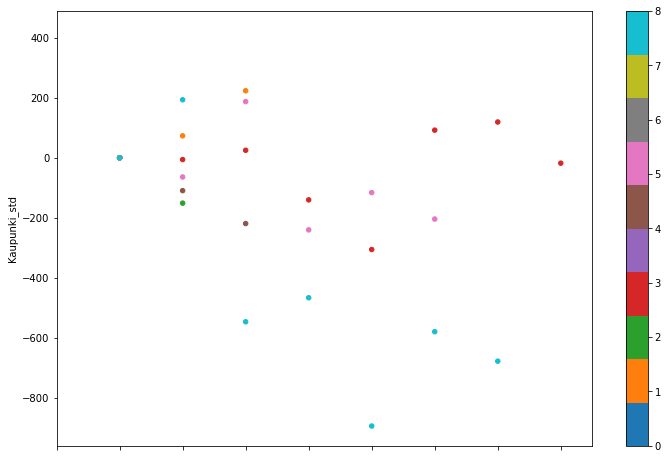

In [5]:
experience_data = data.copy()
start_level = data.Kaupunki[data.index.isin(list(clerks.values()))]
experience_data['start_level'] = start_level
experience_data = experience_data.interpolate(method='ffill')
experience_data['Kaupunki_std'] = experience_data.Kaupunki - experience_data.start_level
mapper = {v: k for k, v in enumerate(clerks)}
colors = data.Henkikirjoittaja.map(mapper)
experience = data.index.values - starts + 1
experience_data['experience'] = experience
experience_data.plot(
    kind='scatter',
    x='experience',
    y='Kaupunki_std',
    c=colors,
    cmap=plt.get_cmap('tab10'),
    figsize=(12, 8),
    xlim=(0, 8.5),
)
data.drop(columns=['Henkikirjoittaja'], inplace=True)